# <span style="color:dodgerblue">Time Based Cross Validation</span>

<hr style="border:4px solid purple"></hr>

### Disclaimer
*No offer or invitation is considered to be made if such offer is not authorised or permitted. This is not the basis for any contract to deal in any security or instrument, or for Fullerton Fund Management Company Ltd (UEN: 200312672W) (“Fullerton”) or its affiliates to enter into or arrange any type of transaction. Any investments made are not obligations of, deposits in, or guaranteed by Fullerton. The contents herein may be amended without notice. Fullerton, its affiliates and their directors and employees, do not accept any liability from the use of this publication.*

*References to specific securities are for illustration purpose only and does not represent Fullerton’s current view of the security or constitute any recommendation.*


# <span style="color:green">Imports and Configurations</span>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn import metrics
import yfinance as yf
import lightgbm as lgb

import datetime
from datetime import datetime as dt
from dateutil.relativedelta import *

# Widen notebook cells
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

C:\Users\shihui\AppData\Local\Temp\ipykernel_37596\4102512491.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


<hr style="border:4px solid purple"></hr>

# <span style="color:green">Utility Functions</span>

In [2]:
# calculate change in price/volume
def calculate_rolling_pct_chg(df, rolling_window):
    df_rolling_returns = df / df.shift(rolling_window) - 1.0
    return df_rolling_returns

<hr style="border:4px solid purple"></hr>

# <span style="color:green">Data Extraction and Feature Engineering</span>

In [3]:
# pull historical prices (adjusted close, close, high, low, open) and volumes
ticker_list = ['AAPL', 'MSFT', 'INTC','NVDA','AMZN','GOOGL']
start = datetime.datetime(2011,1,1)
end = datetime.datetime(2023,7,31)
df_raw = yf.download(ticker_list, start=start, end=end)
df_raw.tail(5)

[*********************100%***********************]  6 of 6 completed


Adj Close                                                 \
                  AAPL        AMZN       GOOGL       INTC        MSFT   
Date                                                                    
2023-07-24  192.490067  128.800003  121.529999  33.509445  344.380859   
2023-07-25  193.358887  129.130005  122.209999  33.977760  350.238464   
2023-07-26  194.237701  128.149994  129.270004  34.236828  337.056366   
2023-07-27  192.959427  128.250000  129.399994  34.426147  330.021271   
2023-07-28  195.565918  132.210007  132.580002  36.697975  337.655090   

                             Close                                     ...  \
                  NVDA        AAPL        AMZN       GOOGL       INTC  ...   
Date                                                                   ...   
2023-07-24  446.119995  192.750000  128.800003  121.529999  33.630001  ...   
2023-07-25  456.790009  193.619995  129.130005  122.209999  34.099998  ...   
2023-07-26  454.519989  194.500000  128.149994  129.270004  34.360001  ...   
2023-07-27  459.000000  193.220001  128.250000  129.399994  34.549999  ...   
2023-07-28  467.500000  195.830002  132.210007  132.580002  36.830002  ...   

                  Open                                       Volume            \
                 GOOGL       INTC        MSFT        NVDA      AAPL      AMZN   
Date                                                                            
2023-07-24  121.660004  33.840000  345.850006  447.309998  45377800  45591100   
2023-07-25  121.360001  33.700001  347.109985  449.410004  37283200  39236700   
2023-07-26  130.070007  33.720001  341.440002  460.209991  47471900  53910100   
2023-07-27  131.669998  34.820000  340.480011  465.190002  47460200  52610700   
2023-07-28  130.779999  36.750000  333.670013  466.679993  48291400  46317400   

                                                    
               GOOGL      INTC      MSFT      NVDA  
Date                                                
2023-07-24  29686100  25225800  26678100  38251600  
2023-07-25  52509600  31771100  41637700  34808100  
2023-07-26  61682100  32643200  58383700  36423700  
2023-07-27  44952100  58890800  39635300  45597600  
2023-07-28  36591200  90863000  28484900  33119400  

[5 rows x 36 columns]

In [4]:
# transform wide table to long table and index by date and ticker
# for price, we use adjusted close because it takes into account splits and dividend distributions
df = df_raw.copy()
df_melt = pd.melt(df.reset_index(),id_vars='Date')
df_melt.columns = ['Date','Feature','Ticker','Feature_Value']
df_pivot = df_melt.pivot(index=['Date','Ticker'],columns='Feature',values='Feature_Value')
feature_list = ['Adj Close','Volume']
df_feature = df_pivot[feature_list]
df_feature.sort_index(inplace=True)
df_feature.tail(12)

C:\Users\shihui\AppData\Local\Temp\ipykernel_37596\3619191416.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature.sort_index(inplace=True)


Feature             Adj Close      Volume
Date       Ticker                        
2023-07-27 AAPL    192.959427  47460200.0
           AMZN    128.250000  52610700.0
           GOOGL   129.399994  44952100.0
           INTC     34.426147  58890800.0
           MSFT    330.021271  39635300.0
           NVDA    459.000000  45597600.0
2023-07-28 AAPL    195.565918  48291400.0
           AMZN    132.210007  46317400.0
           GOOGL   132.580002  36591200.0
           INTC     36.697975  90863000.0
           MSFT    337.655090  28484900.0
           NVDA    467.500000  33119400.0

In [5]:
# rolling change in volume over 3m, 6m, 9m, 12m
trading_days_windows = [62, 126, 186, 252]

df_tmp = df_feature[['Volume']].unstack()
lst_df_rolling_returns_tmp = [calculate_rolling_pct_chg(df_tmp, w).stack() for w in trading_days_windows]
df_rolling_vol = pd.concat(lst_df_rolling_returns_tmp, axis=1)
df_rolling_vol.columns = [f'Vol({w}D)' for w in trading_days_windows]
df_rolling_vol.tail(12)

Vol(62D)  Vol(126D)  Vol(186D)  Vol(252D)
Date       Ticker                                           
2023-07-27 AAPL   -0.268744  -0.278713  -0.565304  -0.139258
           AMZN   -0.649171  -0.441865  -0.594070  -0.215645
           GOOGL  -0.102559   0.061944  -0.259571  -0.063322
           INTC   -0.021523   1.083303   0.045923   0.639248
           MSFT   -0.146942  -0.404219  -0.019525   0.007302
           NVDA    0.208969   0.014324  -0.218031   0.146057
2023-07-28 AAPL   -0.125302  -0.107452  -0.706903  -0.385767
           AMZN   -0.645254  -0.324066  -0.792423  -0.247874
           GOOGL   0.012490   0.215089  -0.162621  -0.388705
           INTC    0.132536   0.620005  -0.009081   1.134357
           MSFT   -0.218451  -0.148548  -0.299225  -0.380682
           NVDA    0.135443  -0.323452  -0.364360  -0.418729

In [6]:
# rolling change in price over 3m, 6m, 9m, 12m
df_tmp = df_feature[['Adj Close']].unstack()
lst_df_rolling_returns_tmp = [calculate_rolling_pct_chg(df_tmp, w).stack() for w in trading_days_windows]
df_rolling_returns = pd.concat(lst_df_rolling_returns_tmp, axis=1)
df_rolling_returns.columns = [f'Rtn({w}D)' for w in trading_days_windows]
df_rolling_returns.tail(12)

Rtn(62D)  Rtn(126D)  Rtn(186D)  Rtn(252D)
Date       Ticker                                           
2023-07-27 AAPL    0.148906   0.366013   0.340498   0.282149
           AMZN    0.167820   0.319716   0.155822   0.117063
           GOOGL   0.202714   0.358958   0.403166   0.232146
           INTC    0.161804   0.182296   0.354718  -0.077317
           MSFT    0.087304   0.380961   0.469502   0.325593
           NVDA    0.686063   1.376057   2.485450   1.778560
2023-07-28 AAPL    0.155710   0.364270   0.263170   0.256454
           AMZN    0.253770   0.332494   0.278503   0.092916
           GOOGL   0.235141   0.359516   0.376882   0.172652
           INTC    0.190625   0.243982   0.305022  -0.046292
           MSFT    0.103657   0.370803   0.445360   0.271269
           NVDA    0.684920   1.361518   2.381144   1.630053

In [7]:
# merge rolling volume and rolling return
df_X = pd.merge(df_rolling_vol, df_rolling_returns, how='outer', left_index=True, right_index=True)
df_X.dropna(inplace=True)
df_X.tail(12)

Vol(62D)  Vol(126D)  Vol(186D)  Vol(252D)  Rtn(62D)  \
Date       Ticker                                                        
2023-07-27 AAPL   -0.268744  -0.278713  -0.565304  -0.139258  0.148906   
           AMZN   -0.649171  -0.441865  -0.594070  -0.215645  0.167820   
           GOOGL  -0.102559   0.061944  -0.259571  -0.063322  0.202714   
           INTC   -0.021523   1.083303   0.045923   0.639248  0.161804   
           MSFT   -0.146942  -0.404219  -0.019525   0.007302  0.087304   
           NVDA    0.208969   0.014324  -0.218031   0.146057  0.686063   
2023-07-28 AAPL   -0.125302  -0.107452  -0.706903  -0.385767  0.155710   
           AMZN   -0.645254  -0.324066  -0.792423  -0.247874  0.253770   
           GOOGL   0.012490   0.215089  -0.162621  -0.388705  0.235141   
           INTC    0.132536   0.620005  -0.009081   1.134357  0.190625   
           MSFT   -0.218451  -0.148548  -0.299225  -0.380682  0.103657   
           NVDA    0.135443  -0.323452  -0.364360  -0.418729  0.684920   

                   Rtn(126D)  Rtn(186D)  Rtn(252D)  
Date       Ticker                                   
2023-07-27 AAPL     0.366013   0.340498   0.282149  
           AMZN     0.319716   0.155822   0.117063  
           GOOGL    0.358958   0.403166   0.232146  
           INTC     0.182296   0.354718  -0.077317  
           MSFT     0.380961   0.469502   0.325593  
           NVDA     1.376057   2.485450   1.778560  
2023-07-28 AAPL     0.364270   0.263170   0.256454  
           AMZN     0.332494   0.278503   0.092916  
           GOOGL    0.359516   0.376882   0.172652  
           INTC     0.243982   0.305022  -0.046292  
           MSFT     0.370803   0.445360   0.271269  
           NVDA     1.361518   2.381144   1.630053

In [8]:
# label data as positive if return >5%, otherwise negative
# this is a binary classification
rtn_threshold = 0.05

# predict 3 months forward return, whether return is >5% or otherwise
rolling_window_for_labeling = 62 # in days

df_rtn = df_rolling_returns[f'Rtn({rolling_window_for_labeling}D)'].unstack().shift(-rolling_window_for_labeling)
df_y = pd.melt(df_rtn.reset_index(),id_vars='Date',value_name=f'Rtn({rolling_window_for_labeling}D)')
df_y['y'] = df_y[f'Rtn({rolling_window_for_labeling}D)'].apply(lambda x: 1 if x>rtn_threshold else 0)
df_y.dropna(inplace=True)
df_y.drop(f'Rtn({rolling_window_for_labeling}D)',axis=1,inplace=True)
df_y = df_y.sort_values(['Date','Ticker']).set_index(['Date','Ticker'])
df_y.tail(12)

y
Date       Ticker   
2023-04-27 AAPL    1
           AMZN    1
           GOOGL   1
           INTC    1
           MSFT    1
           NVDA    1
2023-04-28 AAPL    1
           AMZN    1
           GOOGL   1
           INTC    1
           MSFT    1
           NVDA    1

In [9]:
# combine all features and label (y) in the same dataframe
# then split into train and test data based on time
df_Xy_full = pd.merge(df_X, df_y, how='inner', left_index=True, right_index=True)
df_Xy_full.sort_index(inplace=True)
end_date_for_train = '2021-01-04' # first working day of 2021
df_Xy_train = df_Xy_full.loc[pd.IndexSlice[:end_date_for_train, :]]
df_Xy_test = df_Xy_full.iloc[len(df_Xy_train):,:]

# split df into X and y respectively
df_X_train = df_Xy_train.drop('y',axis=1)
df_y_train = df_Xy_train['y']
df_X_test = df_Xy_test.drop('y',axis=1)
df_y_test = df_Xy_test['y']

print(f'number of train data   = {len(df_Xy_train)}, from {df_Xy_train.index[0][0].date()} to {df_Xy_train.index[-1][0].date()}')
print(f'number of test data    = {len(df_Xy_test)},  from {df_Xy_test.index[0][0].date()} to {df_Xy_test.index[-1][0].date()}')

number of train data   = 13596, from 2012-01-03 to 2021-01-04
number of test data    = 3498,  from 2021-01-05 to 2023-04-28


In [10]:
# check distribution of labels
df_train_cnt = df_Xy_train.groupby('y')['y'].count().reset_index(name='count')
df_train_cnt['name'] = 'train'
df_Xy_test_cnt = df_Xy_test.groupby('y')['y'].count().reset_index(name='count')
df_Xy_test_cnt['name'] = 'test'
df_tmp = pd.concat([df_train_cnt,df_Xy_test_cnt])
df_tmp = pd.pivot(df_tmp, index='name',columns='y',values='count').reset_index()
df_tmp.set_index('name',inplace=True)
df_tmp = df_tmp / df_tmp.sum(axis=1).values.reshape(-1, 1)
df_tmp.columns = [f'rtn <= {rtn_threshold*100}%', f'rtn > {rtn_threshold*100}%']
df_tmp

,rtn <= 5.0%,rtn > 5.0%
name,,
test,0.565466,0.434534
train,0.441600,0.558400


<hr style="border:4px solid purple"></hr>

# <span style="color:green">K-fold Cross Validation without temporal consideration</span>
## Limitation of traditional k-fold CV
This will introduce look-ahead bias because training fold includes future data and validation fold includes past data.


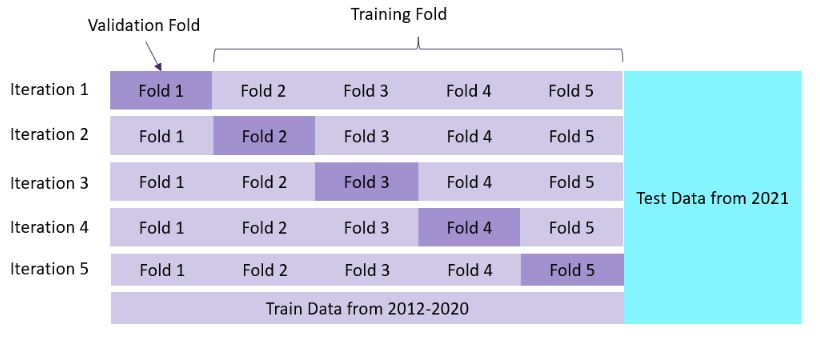

In [11]:
%%time
# grid search with k-fold cv
estimator = lgb.LGBMClassifier()

# Try your own ranges here, you may find better ones than me!
param_grid = {
    'n_estimators': range(5,50,5),
    'num_leaves': range(5,50,10),
    'learning_rate': [0.05, 0.1],
    'colsample_bytree': [0.8, 1.0],
    'max_depth': [-1],
    'reg_alpha': [0, 1],
    'reg_lambda': [0, 1],
    'random_state': [0],
}

grid_lgb = GridSearchCV(
    estimator, param_grid, cv=KFold(n_splits=5), refit=True, scoring='f1', return_train_score=True)

grid_lgb.fit(
    df_X_train,
    df_y_train)

print('Best parameters found by grid search are:', grid_lgb.best_params_)

Best parameters found by grid search are: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 5, 'num_leaves': 25, 'random_state': 0, 'reg_alpha': 1, 'reg_lambda': 1}
CPU times: total: 1h 14min 37s
Wall time: 5min 42s


In [12]:
# training fold includes future data, which will result in look-ahead bias
for train, test in grid_lgb.cv.split(df_X_train):
    print('Train: ', train, '\tValidation: ', test)

Train:  [ 2720  2721  2722 ... 13593 13594 13595] 	Validation:  [   0    1    2 ... 2717 2718 2719]
Train:  [    0     1     2 ... 13593 13594 13595] 	Validation:  [2720 2721 2722 ... 5436 5437 5438]
Train:  [    0     1     2 ... 13593 13594 13595] 	Validation:  [5439 5440 5441 ... 8155 8156 8157]
Train:  [    0     1     2 ... 13593 13594 13595] 	Validation:  [ 8158  8159  8160 ... 10874 10875 10876]
Train:  [    0     1     2 ... 10874 10875 10876] 	Validation:  [10877 10878 10879 ... 13593 13594 13595]


In [13]:
# use the best parameters from gridsearchcv to predict train and test
y_train_pred = grid_lgb.predict(df_X_train)
y_test_pred = grid_lgb.predict(df_X_test)

# classification report for train data
print(classification_report(df_y_train, y_train_pred, target_names = [f'rtn <= {rtn_threshold*100}%', f'rtn > {rtn_threshold*100}%'], zero_division=0))

# classification report for test data
print(classification_report(df_y_test, y_test_pred, target_names = [f'rtn <= {rtn_threshold*100}%', f'rtn > {rtn_threshold*100}%'], zero_division=0))

              precision    recall  f1-score   support

 rtn <= 5.0%       0.86      0.00      0.01      6004
  rtn > 5.0%       0.56      1.00      0.72      7592

    accuracy                           0.56     13596
   macro avg       0.71      0.50      0.36     13596
weighted avg       0.69      0.56      0.40     13596

              precision    recall  f1-score   support

 rtn <= 5.0%       1.00      0.00      0.00      1978
  rtn > 5.0%       0.43      1.00      0.61      1520

    accuracy                           0.44      3498
   macro avg       0.72      0.50      0.30      3498
weighted avg       0.75      0.44      0.27      3498



<hr style="border:4px solid purple"></hr>

# <span style="color:green">K-fold <ins>Time Based</ins> Cross Validation</span>


## Limitations of TimeSeriesSplit method in Scikit-learn
- Splits data into train-test sets in a sliding window approach based on the given train set size and test set size. So it creates sets containing a fixed number of **records**, instead of fixed number of **days**.
- Most importantly, it **assumes there is one observation per date**. In this example, we have 6 observations (because we have 6 tickers) per date.

## Suggested solution from [Medium article](https://medium.com/towards-data-science/time-based-cross-validation-d259b13d42b8)
- The author, Or Herman-Saffar has written a solution to **consider the window size of train and test in terms of days** (and not in terms of records).
- The returned CV splits works like any other scikit-learn cross validator and could be used with any of the methods.

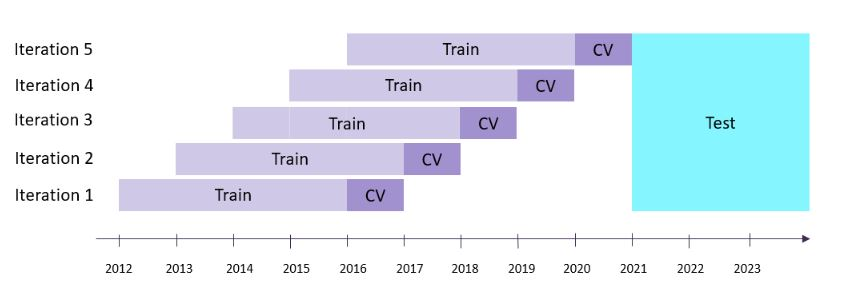

In [14]:
class TimeBasedCV(object):
    '''
    Parameters 
    ----------
    train_period: int
        number of time units to include in each train set
        default is 30
    test_period: int
        number of time units to include in each test set
        default is 7
    freq: string
        frequency of input parameters. possible values are: days, months, years, weeks, hours, minutes, seconds
        possible values designed to be used by dateutil.relativedelta class
        deafault is days
    '''
    
    
    def __init__(self, train_period=30, test_period=7, freq='days'):
        self.train_period = train_period
        self.test_period = test_period
        self.freq = freq

        
    def split(self, data, validation_split_date=None, date_column='record_date', gap=0):
        '''
        Generate indices to split data into training and test set
        
        Parameters 
        ----------
        data: pandas DataFrame
            your data, contain one column for the record date 
        validation_split_date: datetime.date()
            first date to perform the splitting on.
            if not provided will set to be the minimum date in the data after the first training set
        date_column: string, deafult='record_date'
            date of each record
        gap: int, default=0
            for cases the test set does not come right after the train set,
            *gap* days are left between train and test sets
        
        Returns 
        -------
        train_index ,test_index: 
            list of tuples (train index, test index) similar to sklearn model selection
        '''
        
        # check that date_column exist in the data:
        try:
            data[date_column]
        except:
            raise KeyError(date_column)
                    
        train_indices_list = []
        test_indices_list = []

        if validation_split_date==None:
            validation_split_date = data[date_column].min().date() + eval('relativedelta('+self.freq+'=self.train_period)')
        
        start_train = validation_split_date - eval('relativedelta('+self.freq+'=self.train_period)')
        end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
        start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
        end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')
        
        while end_test < data[date_column].max().date():
            # train indices:
            cur_train_indices = list(data[(data[date_column].dt.date>=start_train) & 
                                     (data[date_column].dt.date<end_train)].index)

            # test indices:
            cur_test_indices = list(data[(data[date_column].dt.date>=start_test) &
                                    (data[date_column].dt.date<end_test)].index)
            
            print("Train period:",start_train,"-" , end_train, ", Test period", start_test, "-", end_test,
                  "# train records", len(cur_train_indices), ", # test records", len(cur_test_indices))

            train_indices_list.append(cur_train_indices)
            test_indices_list.append(cur_test_indices)

            # update dates:
            start_train = start_train + eval('relativedelta('+self.freq+'=self.test_period)')
            end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
            start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
            end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')


        # mimic sklearn output  
        index_output = [(train,test) for train,test in zip(train_indices_list,test_indices_list)]

        self.n_splits = len(index_output)
        
        return index_output
    
    
    def get_n_splits(self):
        """Returns the number of splitting iterations in the cross-validator
        Returns
        -------
        n_splits : int
            Returns the number of splitting iterations in the cross-validator.
        """
        return self.n_splits

In [15]:
train_period = 4
test_period = 1

data_for_modeling = df_X_train.reset_index().drop('Ticker',axis=1)
tscv = TimeBasedCV(train_period=train_period,
                   test_period=test_period,
                   freq='years')
index_output = tscv.split(data_for_modeling, date_column='Date')
print(f'number of splits: {tscv.get_n_splits()}')

Train period: 2012-01-03 - 2016-01-03 , Test period 2016-01-03 - 2017-01-03 # train records 6036 , # test records 1512
Train period: 2013-01-03 - 2017-01-03 , Test period 2017-01-03 - 2018-01-03 # train records 6042 , # test records 1512
Train period: 2014-01-03 - 2018-01-03 , Test period 2018-01-03 - 2019-01-03 # train records 6042 , # test records 1506
Train period: 2015-01-03 - 2019-01-03 , Test period 2019-01-03 - 2020-01-03 # train records 6036 , # test records 1512
Train period: 2016-01-03 - 2020-01-03 , Test period 2020-01-03 - 2021-01-03 # train records 6042 , # test records 1512
number of splits: 5


In [16]:
grid_lgb_timebased = GridSearchCV(
    estimator, param_grid, cv=index_output, refit=True, scoring='f1', return_train_score=True)

grid_lgb_timebased.fit(
    df_X_train,
    df_y_train)

print('Best parameters found by grid search are:', grid_lgb_timebased.best_params_)

Best parameters found by grid search are: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 5, 'num_leaves': 5, 'random_state': 0, 'reg_alpha': 1, 'reg_lambda': 1}


In [17]:
y_train_pred = grid_lgb_timebased.predict(df_X_train)
y_test_pred = grid_lgb_timebased.predict(df_X_test)

# train data
print(classification_report(df_y_train, y_train_pred, target_names = [f'rtn <= {rtn_threshold*100}%', f'rtn > {rtn_threshold*100}%']))

# test data
print(classification_report(df_y_test, y_test_pred, target_names = [f'rtn <= {rtn_threshold*100}%', f'rtn > {rtn_threshold*100}%']))

              precision    recall  f1-score   support

 rtn <= 5.0%       0.84      0.02      0.05      6004
  rtn > 5.0%       0.56      1.00      0.72      7592

    accuracy                           0.57     13596
   macro avg       0.70      0.51      0.38     13596
weighted avg       0.68      0.57      0.42     13596

              precision    recall  f1-score   support

 rtn <= 5.0%       0.76      0.01      0.02      1978
  rtn > 5.0%       0.44      1.00      0.61      1520

    accuracy                           0.44      3498
   macro avg       0.60      0.50      0.31      3498
weighted avg       0.62      0.44      0.27      3498

